# Ch3 : Mapping Threads to Multidimensional Data

> Parallelization of 2D vector operation

<div style="display: flex; justify-content: space-between; align-items: center;">
  <span>📅 09/01/2026</span>
  <p align="right">
    <a href="https://colab.research.google.com/github/tripathysagar/PMPP/blob/main/nbs/03_ch3.ipynb" target="_blank">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
   </p>
</div>

In [ ]:
#| default_exp ch3

In [2]:
#|hide
%%capture
import sys
##
#If running in colab please switch run time to use GPU for leveraging CUDA.
##

# Check if running in Google Colab
if 'google.colab' in sys.modules:
  !git clone https://github.com/tripathysagar/PMPP.git
  %cd PMPP
  !pip install -e .


from PMPP.core import *


CUDA threads are organized in a two level hierarchy

1. A grid consists of one or more blocks
1. Each block consists of one or more threads

Both grids and blocks can be 3D arrays (with x, y, z dimensions). You specify these dimensions when launching a kernel. These variables can be wrapped in **dim3** type. As the no of threads inside a block should not exceed 1024, we have to obey the constrain `blockDim.x * blockDim.y * blockDim.z ≤ 1024`. The ordering of the attributes in the dim3 object is lowest dim first i.e. (x, y, z). Note: diagrams often label dimensions in reverse order (z, y, x).

**The built-in variables are:**

- `blockIdx` — the block's coordinates in the grid
- `threadIdx` — the thread's coordinates within its block
- `gridDim` — dimensions of the grid
- `blockDim` — dimensions of each block

Each have 3D attributes.

**Important limits:**
- Max **1024 threads per block** (total across all dimensions)
- `gridDim.x` can go up to 2³¹-1
- `gridDim.y` and `gridDim.z` can go up to 65,535
- `Index ranges`: `blockIdx.x` ranges from 0 to gridDim.x - 1. Same pattern for y and z

The data itself is ordered in row-major order in the memory( C/C++/Python use row-major). This affects how threads are allocated and how we access them. 2D arrays are "flattened" to 1D in memory. This abstraction is substituted with simple indexing.  Index in the 1D space can be found out by following formula : `index = row * width + col`. Where row and col are the global coordinates of the thread in the 2D data space.

```
row = blockIdx.y * blockDim.y + threadIdx.y
col = blockIdx.x * blockDim.x + threadIdx.x
```

When doing operation in 2D or 3D space in GPU, the above constraint comes into play. If the 2D array size is smaller respective to the assigned space inside the GPU there would be many extra threads at the end. Below formula is used to allocate the grid size:

```
gridDim.x = ceil(width / blockDim.x)
gridDim.y = ceil(height / blockDim.y)
```

One has to build proper boundary condition to prevent invalid threads from accessing out-of-bounds memory. The boundary check pattern:

```
if row < height and col < width:
    # do work
```

In [3]:
#|hide
import numpy as np
from numba import cuda

In [4]:
!wget -q https://upload.wikimedia.org/wikipedia/commons/3/3b/BlkStdSchnauzer2.jpg -O dog.jpg
!file dog.jpg

dog.jpg: JPEG image data, JFIF standard 1.01, aspect ratio, density 1x1, segment length 16, baseline, precision 8, 477x387, components 3


In [5]:
from PIL import Image
img = Image.open('dog.jpg')
img.size

(477, 387)

In numpy the image is order by height, width then channel.

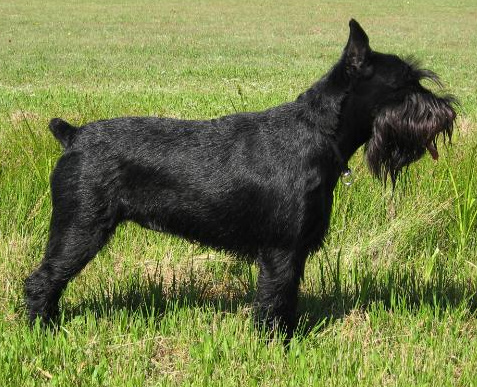

In [6]:
W, H = img.size
#im = img.resize(( W, H))
im = img
im

In [7]:
imn = np.array(im)
assert imn.shape == (H, W, 3)
imn.shape, imn.dtype

((387, 477, 3), dtype('uint8'))



## Converting RGB to Grayscale

The most common formula for converting an RGB pixel to grayscale is a **weighted average** that accounts for human perception of brightness:

```
Gray = 0.299 × R + 0.587 × G + 0.114 × B
```

This gives more weight to green (we're most sensitive to it) and less to blue (least sensitive).


### CPU

In [8]:
def grayscale_cpu(inp, out, height, width):
    #height, width = inp.shape[:2] this will be additional look up

    for row in range(height):
        for col in range(width):
          if row < height and col < width:
              # do work
              out[row, col] = 0.21 * inp[row, col, 0] + 0.72 * inp[row, col, 1] +  0.07 * inp[row, col, 2]


In [9]:
out_c = np.zeros_like(imn, dtype=np.float32)
out_c.shape, out_c.dtype

((387, 477, 3), dtype('float32'))

In [10]:
with timer():
  grayscale_cpu(imn, out_c, H, W)


1139.7589 ms


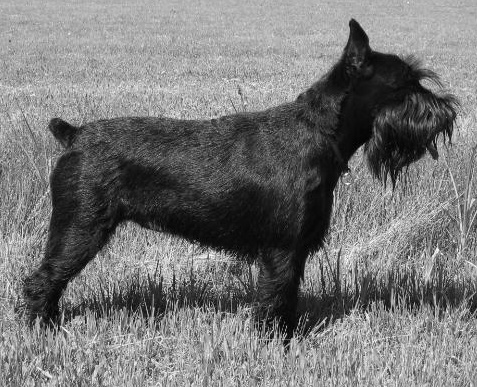

In [11]:
def np2im(arr): return Image.fromarray(arr.astype(np.uint8))
np2im(out_c)

### GPU

Creating output array in the GPU.

In [12]:
out_d = cuda.device_array((H, W), dtype=np.float32)
out_d.shape, device(out_d)

((387, 477), 'cuda')

Moving image to the GPU.

In [13]:
d_im = cuda.to_device(im)
d_im.shape, device(d_im)

((387, 477, 3), 'cuda')

In [14]:
block_dim = (32, 32)
grid_dim = (dim(W, block_dim[0]), dim(H, block_dim[1]))
grid_dim

(15, 13)

In [15]:
@cuda.jit
def grayscale_kernel(inp, out, height, width):
    #height, width = inp.shape[:2] this will be additional look up

    col = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    row = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    if row < height and col < width:
        # do work
        out[row, col] = 0.21 * inp[row, col, 0] + 0.72 * inp[row, col, 1] +  0.07 * inp[row, col, 2]

In [16]:
with timer():
  grayscale_kernel[grid_dim, block_dim](d_im, out_d, H, W)

1283.8546 ms


In [17]:
out = out_d.copy_to_host()
device(out)

'cpu'

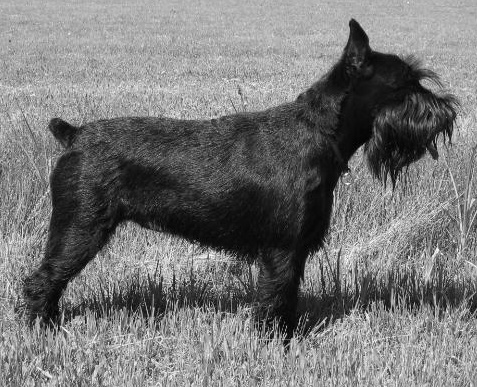

In [18]:
np2im(out_c)

In [19]:
assert test_close(out, out_c[:, :, 0])

## Blurr Filter


A blur effect is created by convolving an image with a **blur kernel** (also called a filter). The basic idea: each pixel becomes an average of itself and its neighbors.

**Simple Box Blur Kernel (3×3):**

```
1/9 * | 1  1  1 |
      | 1  1  1 |
      | 1  1  1 |
```

This averages all 9 pixels in a 3×3 neighborhood equally.



In [20]:
BLUR_SIZE = 3
ks = BLUR_SIZE * 2 + 1
K = np.ones((ks, ks), dtype=np.float32) / ks ** 2
K

array([[0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
        0.02040816, 0.02040816],
       [0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
        0.02040816, 0.02040816],
       [0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
        0.02040816, 0.02040816],
       [0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
        0.02040816, 0.02040816],
       [0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
        0.02040816, 0.02040816],
       [0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
        0.02040816, 0.02040816],
       [0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
        0.02040816, 0.02040816]], dtype=float32)

### CPU

In [22]:
def blurr_cpu(inp, out, K, BLUR_SIZE):
    height, width = inp.shape[:2]

    for row in range(height):
        for col in range(width):
            for i in range(-BLUR_SIZE, BLUR_SIZE + 1):
                for j in range(-BLUR_SIZE, BLUR_SIZE + 1):
                    n_row = row + i
                    n_col = col + j
                    if 0 <= n_row < height and 0 <= n_col < width:
                        for k in range(3):
                            out[row, col, k] += inp[n_row, n_col, k] * K[i + BLUR_SIZE, j + BLUR_SIZE]


In [23]:
out_c = np.zeros_like(imn, dtype=np.float32)

with timer():
  blurr_cpu(imn, out_c, K, BLUR_SIZE)


24707.4492 ms


In [24]:
out_c.shape == imn.shape

True

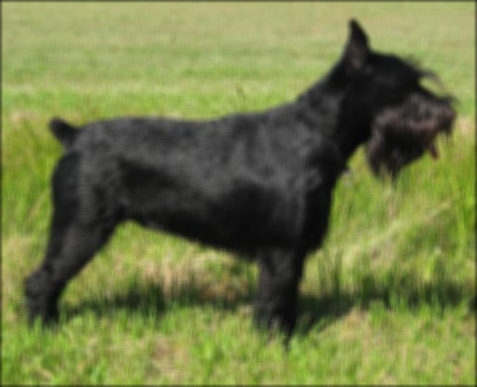

In [25]:
np2im(out_c)

### CPU

In [26]:
def blurr_cpu(inp, out, K, BLUR_SIZE):
    height, width = inp.shape[:2]

    for row in range(height):
        for col in range(width):
            for i in range(-BLUR_SIZE, BLUR_SIZE + 1):
                for j in range(-BLUR_SIZE, BLUR_SIZE + 1):
                    n_row = row + i
                    n_col = col + j
                    if 0 <= n_row < height and 0 <= n_col < width:
                        for k in range(3):
                            out[row, col, k] += inp[n_row, n_col, k] * K[i + BLUR_SIZE, j + BLUR_SIZE]


In [28]:
out_c = np.zeros_like(imn, dtype=np.float32)

with timer():
  blurr_cpu(imn, out_c, K, BLUR_SIZE)

24793.1270 ms


In [29]:
assert out_c.shape == imn.shape

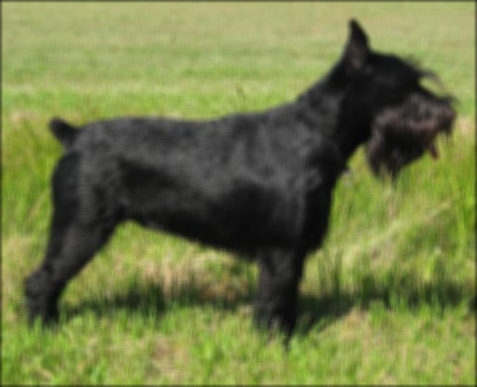

In [30]:
np2im(out_c)

### GPU

In [31]:
@cuda.jit
def blurr_kernel(inp, out, K, height, width, BLUR_SIZE):
    #height, width = inp.shape[:2] this will be additional look up

    col = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    row = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    if row < height and col < width:
        # Initialize the output pixel's color channels to 0.0 before accumulation
        for k in range(3):
            out[row, col, k] = 0.0

        # do work
        for i in range(-BLUR_SIZE, BLUR_SIZE + 1):
            for j in range(-BLUR_SIZE, BLUR_SIZE + 1):
                n_row = row + i
                n_col = col + j
                if 0 <= n_row < height and 0 <= n_col < width:
                    for k in range(3):
                        out[row, col, k] += float(inp[n_row, n_col, k]) * K[i + BLUR_SIZE, j + BLUR_SIZE]

In [32]:
out_d = cuda.device_array((H, W, 3), dtype=np.float32)
out_d.shape, device(out_d)

((387, 477, 3), 'cuda')

In [33]:
d_K = cuda.to_device(K)
with timer():
  blurr_kernel[grid_dim, block_dim](d_im, out_d, d_K, H, W, BLUR_SIZE)

213.6875 ms


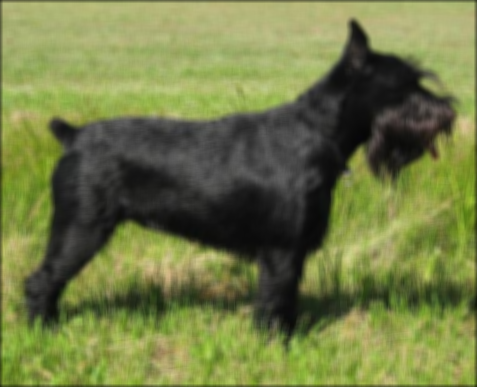

In [34]:
np2im(out_d.copy_to_host())

In [35]:
assert test_close(out_d.copy_to_host(), out_c)

## Mat Mul

In [36]:
Wm, Hm = 120, 140
Wn, Hn = 140, 160
assert Hm == Wn

### CPU

In [37]:
M = np.random.randn(Wm, Hm)
N = np.random.randn(Wn, Hn)
M.shape, N.shape

((120, 140), (140, 160))

In [38]:
P1 = np.zeros((Wm, Hn), dtype=M.dtype)
P1.shape

(120, 160)

In [39]:
def seq_mult():
    for i in range(Wm):
        for j in range(Hn):
            temp = 0
            for k in range(Wn):
                temp += M[i,k] * N[k,j]
            P1[i,j] = temp

In [40]:
with timer():
  seq_mult()

979.2057 ms


### GPU


{{< video https://www.youtube.com/watch?v=Oy6mvI_yqi0 >}}

In [41]:
M_d = cuda.to_device(M)
N_d = cuda.to_device(N)

P_d = cuda.to_device(np.zeros((Wm, Hn), dtype=M.dtype))
device(M_d), device(N_d), device(P_d)

('cuda', 'cuda', 'cuda')

In [42]:
@cuda.jit
def matmul_kernel(M, N, P, W1, H2, W2):
    col = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    row = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    if col < H2 and row < W1:
        p_val = 0.
        for i in range(W2):
            p_val += M[row, i] * N[i, col]

        P[row, col] = p_val

In [43]:
with timer():
  matmul_kernel[grid_dim, block_dim](M_d, N_d, P_d, Wm, Hn, Wn )

128.3623 ms


In [44]:
assert test_close(P1, P_d.copy_to_host())

## Conclusion

| Operation              | CPU Time (ms)      | GPU Time (ms)    |
|------------------------|----------------|--------------|
| Grayscale Conversion   | 1139.7589 ms         | 1283.8546 ms |
| Blur Filter            | 24793.1270 ms        | 213.6875 ms       |
| Matrix Multiplication  | 979.2057 s         | 128.3623 ms       |

GPU are faster for the problems wrt the CPU in **Blur Filter** and **Matrix Multiplication**. But for **Grayscale Conversion** CPU performs marginally better than GPU.